In [15]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import cv2
from tqdm import tqdm
from google.colab.patches import cv2_imshow
from matplotlib.pyplot import imshow
from PIL import Image, ImageOps


import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101
Using the GPU!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [16]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset1 = datasets.EMNIST('../data', train=True, download=True, split="letters",
  transform=transform)
dataset2 = datasets.EMNIST('../data', train=False, download=True, split="letters",
  transform=transform)
'''
dataset1 = datasets.MNIST('../data', train=True, download=True,
  transform=transform)
dataset2 = datasets.MNIST('../data', train=False, download=True,
  transform=transform)
'''


"\ndataset1 = datasets.MNIST('../data', train=True, download=True,\n  transform=transform)\ndataset2 = datasets.MNIST('../data', train=False, download=True,\n  transform=transform)\n"

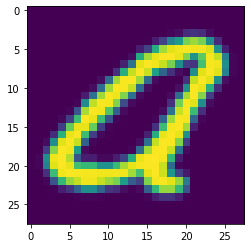

In [17]:
def rotate(img):
  if len(img.shape) == 4:
    return img.permute(0,1,3, 2)
  else:
    return img.permute(0,2, 1)

def num_letter(num):
  return chr(num + 64)

def plot_image(img):
  img = img.squeeze(0)
  plt.imshow(  img )



batch_size_train = 128
batch_size_test = 1024


plot_image(rotate(dataset1[29][0]))

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size_test, shuffle=True)




In [18]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        #self.fc1 = nn.Linear(6400, 128)
        self.fc2 = nn.Linear(128, 26)

    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = F.relu(x)
        x = self.conv2(x)
        #print(x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        #print(x.shape)
        x = self.dropout1(x)
        #print(x.shape)
        x = torch.flatten(x, 1)
        #print(x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = F.relu(x)
        x = self.dropout1(x)
        #print(x.shape)
        x = self.fc2(x)
        x = self.dropout1(x)
        #print(x.shape)
        output = F.log_softmax(x, dim=1)
        #print(output.shape)
        return output



In [19]:
def train(log_interval, model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    running_correct = 0
    total_possible_correct = 0
    all_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        #print(data.shape)
        data, target = data.to(device), target.to(device)
        data = rotate(data)
        optimizer.zero_grad()
        output = model(data)
        preds = torch.argmax(output, dim=1)
        target = target - 1
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        current_correct = torch.sum(preds == target).item()
        running_correct += current_correct
        total_possible_correct += len(preds)
        all_losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return all_losses, running_correct / total_possible_correct
        
            

In [20]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = rotate(data)
            output = model(data)
            target = target - 1
            test_loss += criterion(output, target).sum()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    old_loss = test_loss
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return old_loss.item(), correct / len(test_loader.dataset)

In [21]:
n_epochs = 50
momentum = 0.9
learning_rate = 1e-2
best_acc = 0

test_accuracy_arr = []
train_accuracy_arr = []
loss_arr = []

model = Net().to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adadelta(model.parameters(), lr=learning_rate )
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.4, patience=2)
for epoch in range(1, n_epochs + 1):
    current_losses, train_accuracy = train(100, model, device, train_loader, optimizer, epoch, criterion)
    test_loss, test_accuracy = test(model, device, test_loader, criterion)
    train_accuracy_arr.append(train_accuracy)
    test_accuracy_arr.append(test_accuracy)
    loss_arr += current_losses

    if train_accuracy > best_acc:
      best_acc = train_accuracy
      best_model = copy.deepcopy(model.state_dict())
      torch.save(best_model, './letterModel.dat')
    scheduler.step(test_loss)




Train Epoch: 1 [0/124800 (0%)]	Loss: 3.245846
Train Epoch: 1 [12800/124800 (10%)]	Loss: 1.695140
Train Epoch: 1 [25600/124800 (21%)]	Loss: 1.417881
Train Epoch: 1 [38400/124800 (31%)]	Loss: 1.211511
Train Epoch: 1 [51200/124800 (41%)]	Loss: 1.052142
Train Epoch: 1 [64000/124800 (51%)]	Loss: 1.240582
Train Epoch: 1 [76800/124800 (62%)]	Loss: 1.034353
Train Epoch: 1 [89600/124800 (72%)]	Loss: 1.080160
Train Epoch: 1 [102400/124800 (82%)]	Loss: 1.009310
Train Epoch: 1 [115200/124800 (92%)]	Loss: 0.925003

Test set: Average loss: 0.0003, Accuracy: 18675/20800 (90%)

Train Epoch: 2 [0/124800 (0%)]	Loss: 1.096600
Train Epoch: 2 [12800/124800 (10%)]	Loss: 1.054006
Train Epoch: 2 [25600/124800 (21%)]	Loss: 0.816555
Train Epoch: 2 [38400/124800 (31%)]	Loss: 0.994459
Train Epoch: 2 [51200/124800 (41%)]	Loss: 0.825228
Train Epoch: 2 [64000/124800 (51%)]	Loss: 1.184253
Train Epoch: 2 [76800/124800 (62%)]	Loss: 0.956751
Train Epoch: 2 [89600/124800 (72%)]	Loss: 0.890080
Train Epoch: 2 [102400/12480

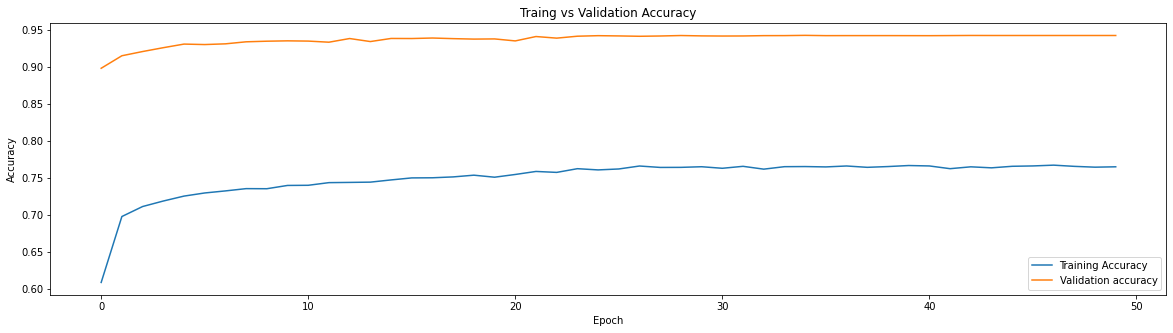

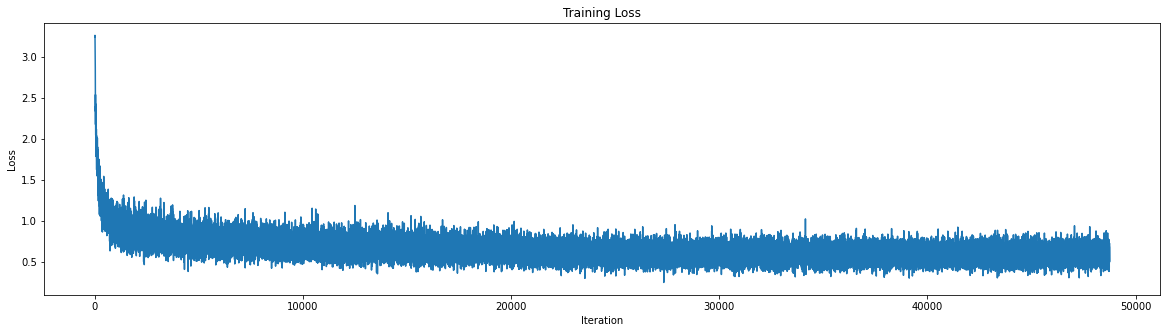

In [22]:
x = np.arange(n_epochs)
x_l = np.arange(len(loss_arr))
plt.rcParams["figure.figsize"] = (20,5)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, train_accuracy_arr)
plt.plot(x, test_accuracy_arr)
plt.legend(['Training Accuracy', 'Validation accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Traing vs Validation Accuracy')
plt.show()


# Training Losses
plt.figure()
plt.plot(x_l, loss_arr)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
o = cv2.imread('w0.PNG')
o = cv2.resize(o, (o.shape[1], o.shape[0]), interpolation = cv2.INTER_AREA)  
gray = cv2.cvtColor(o, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)
gray = transform(gray)
gray = gray.to(device)
model.eval()
output = model(gray[None, ...].float())
pred = output.argmax(dim=1, keepdim=True)

print(chr(pred.item()+65))



A
